# Galaxy vs Quasars 2

We use the data contained in **SDSS** (Sloan Digital Sky Survey) cataloug. It contains multi-band photometric observations of galaxies.

In [1]:
import numpy as np
import pylab as plt
from matplotlib import pyplot as plt
plt.rcParams['figure.figsize'] = [7, 6]
plt.rcParams['font.size'] = 15

In [2]:
import pandas as pd
data = pd.read_csv("galaxyquasar.csv")
data

,u,g,r,i,z,class,z1,zerr
0,18.97213,18.53676,18.58280,18.34936,18.29215,QSO,0.522819,0.000155
1,19.24592,17.47646,16.47817,16.04472,15.68851,GALAXY,0.122846,0.000028
2,19.43536,17.70268,16.91565,16.58327,16.39128,GALAXY,0.000000,0.000000
3,19.31626,18.18312,17.39591,16.94549,16.65395,GALAXY,0.147435,0.000009
4,19.28828,19.11188,18.88937,18.80013,18.49183,QSO,2.011455,0.000631
...,...,...,...,...,...,...,...,...
49995,19.37295,18.12382,17.39886,16.98503,16.70585,GALAXY,0.113016,0.000011
49996,18.52021,16.88262,16.03280,15.56884,15.22454,GALAXY,0.085063,0.000014
49997,18.62718,17.30876,16.87371,16.62399,16.42296,GALAXY,0.054429,0.000008
49998,19.55140,18.27711,17.62101,17.21947,17.03347,GALAXY,0.112571,0.000009


In [3]:
data.columns

Index(['u', 'g', 'r', 'i', 'z', 'class', 'z1', 'zerr'], dtype='object')

## Data exploration

Now we create colors arrays and an array with class labels, 0 = galaxy, 1 = quasar.

In [4]:
ug = np.array(data['u']-data['g'])
gr = np.array(data['g']-data['r'])
ri = np.array(data['r']-data['i'])
iz = np.array(data['i']-data['z'])


from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
data['class'] = le.fit_transform(data['class'])
labels_ = le.inverse_transform(data['class'])
class_names_ = le.classes_
print(class_names_)
print(labels_)


['GALAXY' 'QSO']
['QSO' 'GALAXY' 'GALAXY' ... 'GALAXY' 'GALAXY' 'GALAXY']


Text(0.5, 1.04, 'Corner plot 4-D parameter space')

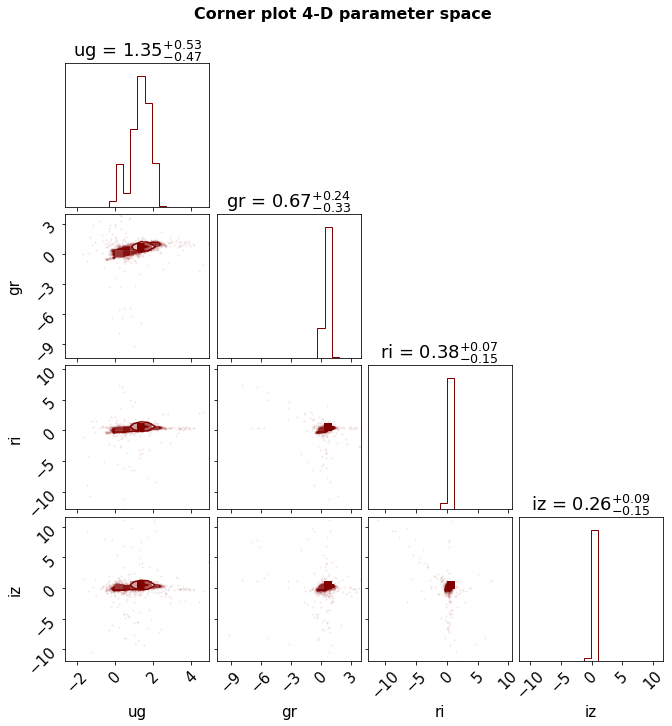

In [5]:
import corner


labels = ["ug", "gr", "ri", "iz"]
fig = corner.corner(np.array([ug, gr, ri, iz]).T, labels=labels, show_titles= True, color = 'maroon');
fig.suptitle('Corner plot 4-D parameter space', fontsize = 16, fontweight="bold",  y=1.04)

The ug color seems more interesting than others.

(0.0, 3.0)

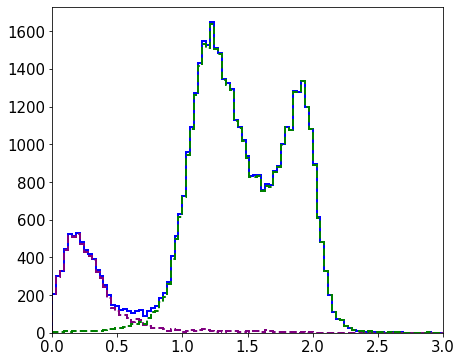

In [6]:
plt.hist(ug,histtype='step',bins=np.linspace(0,3,100), color = 'blue' , linewidth = 2);
plt.hist(ug[labels_ == 'QSO'],histtype='step',bins=np.linspace(0,3,100), color = 'purple', linewidth = 2,  linestyle='--');
plt.hist(ug[labels_ == 'GALAXY'],histtype='step',bins=np.linspace(0,3,100), color = 'green', linewidth = 2, linestyle='--');
plt.xlim(0,3)

The bimodality observed is ascribable to the quasars and galaxies distinction.

In [7]:
# to pass from QSO and GALAXY to 1 and 0

print(class_names_)
data['class'] = le.fit_transform(data['class'])
labels_ = le.inverse_transform(data['class'])
class_names_ = le.classes_
print(class_names_)
print(labels_)

['GALAXY' 'QSO']
[0 1]
[1 0 0 ... 0 0 0]


## Splitting and Preparing of the dataset

I use tensorflow also to split the data into training and validation.

In [8]:
import tensorflow as tf
from tensorflow import keras
from sklearn.preprocessing import StandardScaler

X=np.array([ug, gr, ri, iz]).T
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
print(X_scaled.shape)

#preparing data for tensorflow slicing
dataset = tf.data.Dataset.from_tensor_slices((X_scaled, labels_))

dim_train = int(0.7 * len(X_scaled))
train_dataset = dataset.take(dim_train)
val_dataset = dataset.skip(dim_train)


train_features, train_labels = zip(*list(train_dataset.as_numpy_iterator()))
val_features, val_labels = zip(*list(val_dataset.as_numpy_iterator()))

X_train = np.array(train_features)
y_train = np.array(train_labels)
X_val = np.array(val_features)
y_val = np.array(val_labels)

# just checking
print(X_train.shape)
print(y_train.shape)

(50000, 4)
(35000, 4)
(35000,)


## Classifier 

Let's start from a network architecture with a single hidden layer with **5 neurons**, using the **adam** solver, the **relu** activation function, and a **learninig rate of 0.001**. Plot the resulting ROC curve.


1. ReLU (Rectified Linear Unit) = activation function taking the maximum between (0,z). It's fast;
2. adam = adaptive learning rate algorithm enabling faster convergence compared to standard gradient descent with a constant global learning rate.


A dense neural network is a machine learning model in which each layer is deeply connected to the previous layer.

Sequential is a class in TensorFlow/Keras that allows the creation of neural network models in a linear fashion by adding layers one after another, but here we still use one hiddel layer.



In [9]:
from keras import layers, models, optimizers

model = models.Sequential([
    layers.Flatten(input_shape=(X_train.shape[1],)), # Input layer 
    layers.Dense(5, activation='relu'),      # Hidden layer with 5 neurons and ReLU activation
    layers.Dropout(0.2),                       # Dropout layer to prevent overfitting, 20% of probability of being "dropped out"
    layers.Dense(1, activation='sigmoid')        # Output layer for binary classification
])

optimizer = optimizers.Adam(learning_rate=0.001)

#this loss is common in binary classification   

model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy']) 



C:\Users\LEONARDO\anaconda3\lib\site-packages\keras\src\layers\reshaping\flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [10]:
# batch_ size = the number of samples that will be propagated through the network at a time

history = model.fit(X_train, y_train, epochs=15, validation_data=(X_val, y_val), batch_size=100)

Epoch 1/15
350/350 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.4486 - loss: 0.8614 - val_accuracy: 0.9463 - val_loss: 0.5269
Epoch 2/15
350/350 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9376 - loss: 0.4536 - val_accuracy: 0.9718 - val_loss: 0.2683
Epoch 3/15
350/350 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9634 - loss: 0.2613 - val_accuracy: 0.9759 - val_loss: 0.1787
Epoch 4/15
350/350 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9670 - loss: 0.2055 - val_accuracy: 0.9777 - val_loss: 0.1373
Epoch 5/15
350/350 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9709 - loss: 0.1753 - val_accuracy: 0.9791 - val_loss: 0.1138
Epoch 6/15
350/350 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9748 - loss: 0.1534 - val_accuracy: 0.9806 - val_loss: 0.0998
Epoch 7/15
350/350 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9744 - loss: 0.1341 - val_accuracy: 0.9813 - val_loss: 0.0926
Epoch 8/15
350/350 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9759 - loss: 0.1301 - val_accuracy: 0.

Now we plot the history, a record of the process capturing how the model's performance metrics change over each epoch.

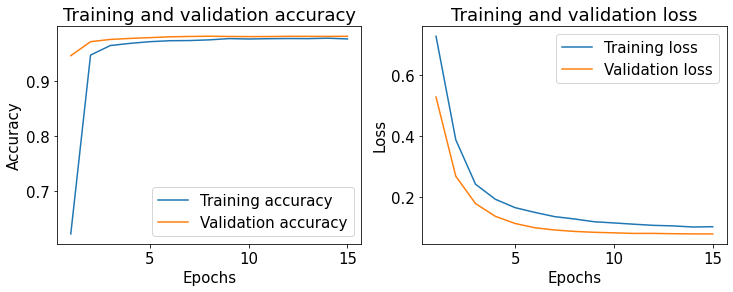

In [11]:
history_dict = history.history

# Extracting accuracy and loss
train_acc = history_dict['accuracy']
val_acc = history_dict['val_accuracy']
train_loss = history_dict['loss']
val_loss = history_dict['val_loss']

# Number of epochs
epochs = range(1, 16)

plt.figure(figsize=(12, 4))


plt.subplot(1, 2, 1)
plt.plot(epochs, train_acc, label='Training accuracy')
plt.plot(epochs, val_acc, label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(epochs, train_loss, label='Training loss')
plt.plot(epochs, val_loss, label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

Now we plot the ROC curve.

469/469 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step


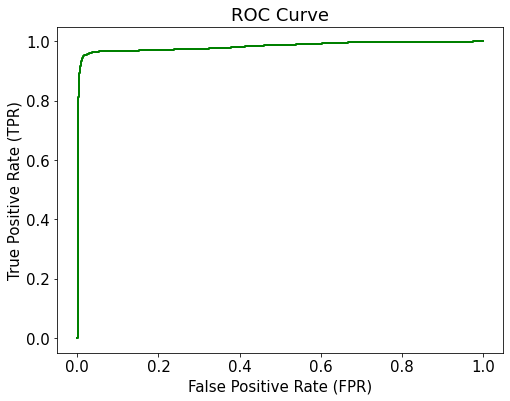

In [14]:
from sklearn.metrics import roc_curve

y_probs = model.predict(X_val).ravel()

fpr, tpr, thresholds = roc_curve(y_val, y_probs)


# Plot della ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='green', lw=2)

plt.xlabel('False Positive Rate (FPR)')
plt.ylabel('True Positive Rate (TPR)')
plt.title('ROC Curve')
plt.show()

## Optimization of hyperparameters

We want to find the optimal hyperparameters and we do that using cross validation.

In particular we analyze the following hyperparameters: number of neurons, dropout, the solver and the activation function.

In [26]:
%reload_ext tensorboard

In [16]:
from tensorflow.keras import callbacks
from tensorboard.plugins.hparams import api as hp


def build_model(neurons=16, dropout_rate=0.2, solver='adam', activation='relu'):
    model = models.Sequential([
        layers.Flatten(input_shape=(X_train.shape[1],)),
        layers.Dense(neurons, activation=activation),
        layers.Dropout(dropout_rate),
        layers.Dense(1, activation='sigmoid')
    ])
    
    if solver == 'adam':
        optimizer = optimizers.Adam(learning_rate=0.001)
    elif solver == 'sgd':
        optimizer = optimizers.SGD(learning_rate=0.01) 

    model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])
    return model



logdir = './logs2/hparam_tuning'
tensorboard_callback = callbacks.TensorBoard(log_dir=logdir, histogram_freq=1)


hp.hparams_config(
    hparams=[hp.HParam('neurons', hp.Discrete([5, 10, 20, 30])),
             hp.HParam('dropout_rate', hp.Discrete([0.2, 0.3, 0.4])),
             hp.HParam('solver', hp.Discrete(['adam', 'sgd'])),
             hp.HParam('activation', hp.Discrete(['relu', 'tanh']))],
    metrics=[hp.Metric('accuracy', display_name='Accuracy')],
)


cv_scores = []


for neurons in [5, 10, 20, 30]:
    for dropout_rate in [0.2, 0.3, 0.4]:
        for solver in ['adam', 'sgd']:
            for activation in ['relu', 'tanh']:
                print(f"Testing model with: neurons={neurons}, dropout={dropout_rate}, solver={solver}, activation={activation}")

                
                split_idx = int(0.7 * len(X))
                X_train, X_val = X[:split_idx], X[split_idx:]
                y_train, y_val = labels_[:split_idx], labels_[split_idx:]

                
                model = build_model(neurons=neurons, dropout_rate=dropout_rate, solver=solver, activation=activation)

                
                with tf.summary.create_file_writer(logdir).as_default():
                    hp.hparams({
                        'neurons': neurons,
                        'dropout_rate': dropout_rate,
                        'solver': solver,
                        'activation': activation,
                    })

                
                model.fit(X_train, y_train, epochs=1, batch_size=100, validation_data=(X_val, y_val),
                          callbacks=[tensorboard_callback])

                
                scores = model.evaluate(X_val, y_val)
                print("Validation Accuracy:", scores[1])
                cv_scores.append(scores[1])


print("Mean Validation Accuracy:", np.mean(cv_scores))


Testing model with: neurons=5, dropout=0.2, solver=adam, activation=relu


C:\Users\LEONARDO\anaconda3\lib\site-packages\keras\src\layers\reshaping\flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/10
350/350 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.5073 - loss: 0.6805 - val_accuracy: 0.8516 - val_loss: 0.3754
Epoch 2/10
350/350 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.8578 - loss: 0.3633 - val_accuracy: 0.8517 - val_loss: 0.2796
Epoch 3/10
350/350 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.8652 - loss: 0.3070 - val_accuracy: 0.8623 - val_loss: 0.2246
Epoch 4/10
350/350 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9020 - loss: 0.2583 - val_accuracy: 0.9545 - val_loss: 0.1691
Epoch 5/10
350/350 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9451 - loss: 0.2008 - val_accuracy: 0.9724 - val_loss: 0.1307
Epoch 6/10
350/350 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9518 - loss: 0.1660 - val_accuracy: 0.9771 - val_loss: 0.1095
Epoch 7/10
350/350 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9571 - loss: 0.1434 - val_accuracy: 0.9789 - val_loss: 0.0978
Epoch 8/10
350/350 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9530 - loss: 0.1393 - val_accuracy: 0.

350/350 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9441 - loss: 0.1330 - val_accuracy: 0.9801 - val_loss: 0.0842
Epoch 7/10
350/350 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9457 - loss: 0.1328 - val_accuracy: 0.9803 - val_loss: 0.0820
Epoch 8/10
350/350 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9409 - loss: 0.1399 - val_accuracy: 0.9804 - val_loss: 0.0806
Epoch 9/10
350/350 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9452 - loss: 0.1267 - val_accuracy: 0.9808 - val_loss: 0.0798
Epoch 10/10
350/350 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9438 - loss: 0.1323 - val_accuracy: 0.9809 - val_loss: 0.0793
469/469 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.9809 - loss: 0.0799
Validation Accuracy: 0.9808666706085205
Testing model with: neurons=5, dropout=0.3, solver=adam, activation=tanh
Epoch 1/10
350/350 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.5148 - loss: 0.7004 - val_accuracy: 0.8517 - val_loss: 0.3500
Epoch 2/10
350/350 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - 

469/469 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9788 - loss: 0.0914
Validation Accuracy: 0.9793333411216736
Testing model with: neurons=5, dropout=0.4, solver=adam, activation=tanh
Epoch 1/10
350/350 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - accuracy: 0.5793 - loss: 0.6522 - val_accuracy: 0.8523 - val_loss: 0.3155
Epoch 2/10
350/350 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.8599 - loss: 0.3303 - val_accuracy: 0.8543 - val_loss: 0.2545
Epoch 3/10
350/350 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.8702 - loss: 0.2676 - val_accuracy: 0.9210 - val_loss: 0.1950
Epoch 4/10
350/350 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.9242 - loss: 0.2117 - val_accuracy: 0.9645 - val_loss: 0.1486
Epoch 5/10
350/350 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.9517 - loss: 0.1743 - val_accuracy: 0.9733 - val_loss: 0.1202
Epoch 6/10
350/350 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.9611 - loss: 0.1536 - val_accuracy: 0.9764 - val_loss: 0.1033
Epoch 7/10
350/350 ━━━━━━━━━━━━━━━━━━━━ 1s 4

350/350 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9505 - loss: 0.1625 - val_accuracy: 0.9755 - val_loss: 0.1218
Epoch 5/10
350/350 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9740 - loss: 0.1235 - val_accuracy: 0.9799 - val_loss: 0.0973
Epoch 6/10
350/350 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9788 - loss: 0.1024 - val_accuracy: 0.9808 - val_loss: 0.0862
Epoch 7/10
350/350 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9793 - loss: 0.0949 - val_accuracy: 0.9811 - val_loss: 0.0802
Epoch 8/10
350/350 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9800 - loss: 0.0909 - val_accuracy: 0.9812 - val_loss: 0.0768
Epoch 9/10
350/350 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9811 - loss: 0.0841 - val_accuracy: 0.9811 - val_loss: 0.0748
Epoch 10/10
350/350 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9812 - loss: 0.0843 - val_accuracy: 0.9814 - val_loss: 0.0735
469/469 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.9818 - loss: 0.0745
Validation Accuracy: 0.9814000129699707

350/350 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9807 - loss: 0.0881 - val_accuracy: 0.9810 - val_loss: 0.0714
Epoch 10/10
350/350 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9815 - loss: 0.0834 - val_accuracy: 0.9819 - val_loss: 0.0709
469/469 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.9822 - loss: 0.0719
Validation Accuracy: 0.9819333553314209
Testing model with: neurons=10, dropout=0.3, solver=sgd, activation=relu
Epoch 1/10
350/350 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.6950 - loss: 0.5659 - val_accuracy: 0.8513 - val_loss: 0.3152
Epoch 2/10
350/350 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.8580 - loss: 0.3388 - val_accuracy: 0.8513 - val_loss: 0.2742
Epoch 3/10
350/350 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.8557 - loss: 0.3035 - val_accuracy: 0.8513 - val_loss: 0.2425
Epoch 4/10
350/350 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.8585 - loss: 0.2720 - val_accuracy: 0.8523 - val_loss: 0.2156
Epoch 5/10
350/350 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - 

350/350 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.8607 - loss: 0.3581 - val_accuracy: 0.8528 - val_loss: 0.2682
Epoch 3/10
350/350 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.8687 - loss: 0.3204 - val_accuracy: 0.8559 - val_loss: 0.2439
Epoch 4/10
350/350 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.8791 - loss: 0.2911 - val_accuracy: 0.8730 - val_loss: 0.2218
Epoch 5/10
350/350 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.8936 - loss: 0.2730 - val_accuracy: 0.8981 - val_loss: 0.2020
Epoch 6/10
350/350 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9070 - loss: 0.2564 - val_accuracy: 0.9289 - val_loss: 0.1836
Epoch 7/10
350/350 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9226 - loss: 0.2351 - val_accuracy: 0.9513 - val_loss: 0.1679
Epoch 8/10
350/350 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9357 - loss: 0.2161 - val_accuracy: 0.9649 - val_loss: 0.1538
Epoch 9/10
350/350 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9407 - loss: 0.2019 - val_accuracy: 0.9714 - val_

350/350 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9119 - loss: 0.2344 - val_accuracy: 0.9483 - val_loss: 0.1726
Epoch 8/10
350/350 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9328 - loss: 0.2185 - val_accuracy: 0.9637 - val_loss: 0.1568
Epoch 9/10
350/350 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9449 - loss: 0.2082 - val_accuracy: 0.9700 - val_loss: 0.1437
Epoch 10/10
350/350 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9558 - loss: 0.1903 - val_accuracy: 0.9737 - val_loss: 0.1334
469/469 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.9722 - loss: 0.1354
Validation Accuracy: 0.9736666679382324
Testing model with: neurons=20, dropout=0.2, solver=sgd, activation=tanh
Epoch 1/10
350/350 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.8612 - loss: 0.3226 - val_accuracy: 0.8661 - val_loss: 0.2152
Epoch 2/10
350/350 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.8800 - loss: 0.2082 - val_accuracy: 0.9281 - val_loss: 0.1723
Epoch 3/10
350/350 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - 

Epoch 1/10
350/350 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.7191 - loss: 0.4789 - val_accuracy: 0.8525 - val_loss: 0.2510
Epoch 2/10
350/350 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.8557 - loss: 0.2489 - val_accuracy: 0.8668 - val_loss: 0.2048
Epoch 3/10
350/350 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.8887 - loss: 0.1949 - val_accuracy: 0.9378 - val_loss: 0.1684
Epoch 4/10
350/350 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9371 - loss: 0.1685 - val_accuracy: 0.9635 - val_loss: 0.1419
Epoch 5/10
350/350 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9615 - loss: 0.1471 - val_accuracy: 0.9725 - val_loss: 0.1235
Epoch 6/10
350/350 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9706 - loss: 0.1299 - val_accuracy: 0.9759 - val_loss: 0.1109
Epoch 7/10
350/350 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9737 - loss: 0.1187 - val_accuracy: 0.9785 - val_loss: 0.1022
Epoch 8/10
350/350 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9784 - loss: 0.1082 - val_accuracy: 0.

350/350 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.9727 - loss: 0.1220 - val_accuracy: 0.9753 - val_loss: 0.1037
Epoch 7/10
350/350 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9741 - loss: 0.1128 - val_accuracy: 0.9769 - val_loss: 0.0968
Epoch 8/10
350/350 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9756 - loss: 0.1109 - val_accuracy: 0.9775 - val_loss: 0.0919
Epoch 9/10
350/350 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9770 - loss: 0.1066 - val_accuracy: 0.9780 - val_loss: 0.0882
Epoch 10/10
350/350 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9779 - loss: 0.0981 - val_accuracy: 0.9783 - val_loss: 0.0856
469/469 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9773 - loss: 0.0869
Validation Accuracy: 0.9782666563987732
Testing model with: neurons=30, dropout=0.2, solver=adam, activation=relu
Epoch 1/10
350/350 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.8765 - loss: 0.2890 - val_accuracy: 0.9727 - val_loss: 0.1227
Epoch 2/10
350/350 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step -

469/469 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.9787 - loss: 0.0866
Validation Accuracy: 0.9792666435241699
Testing model with: neurons=30, dropout=0.3, solver=adam, activation=relu
Epoch 1/10
350/350 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.8240 - loss: 0.4645 - val_accuracy: 0.9649 - val_loss: 0.1604
Epoch 2/10
350/350 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9634 - loss: 0.1488 - val_accuracy: 0.9792 - val_loss: 0.0917
Epoch 3/10
350/350 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9760 - loss: 0.1047 - val_accuracy: 0.9799 - val_loss: 0.0797
Epoch 4/10
350/350 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9769 - loss: 0.0942 - val_accuracy: 0.9804 - val_loss: 0.0771
Epoch 5/10
350/350 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9783 - loss: 0.0896 - val_accuracy: 0.9805 - val_loss: 0.0757
Epoch 6/10
350/350 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9800 - loss: 0.0879 - val_accuracy: 0.9811 - val_loss: 0.0760
Epoch 7/10
350/350 ━━━━━━━━━━━━━━━━━━━━ 1s 

350/350 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9782 - loss: 0.0965 - val_accuracy: 0.9803 - val_loss: 0.0788
Epoch 5/10
350/350 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9795 - loss: 0.0874 - val_accuracy: 0.9809 - val_loss: 0.0780
Epoch 6/10
350/350 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9791 - loss: 0.0957 - val_accuracy: 0.9808 - val_loss: 0.0770
Epoch 7/10
350/350 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9795 - loss: 0.0913 - val_accuracy: 0.9809 - val_loss: 0.0763
Epoch 8/10
350/350 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9800 - loss: 0.0871 - val_accuracy: 0.9809 - val_loss: 0.0764
Epoch 9/10
350/350 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.9788 - loss: 0.0910 - val_accuracy: 0.9809 - val_loss: 0.0764
Epoch 10/10
350/350 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9801 - loss: 0.0894 - val_accuracy: 0.9810 - val_loss: 0.0760
469/469 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.9811 - loss: 0.0748
Validation Accuracy: 0.9810000061988831

In [19]:
tensorboard --logdir=./logs2


The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


In [34]:
print(max(cv_scores))
print(np.argmax(cv_scores))

n_best = 30
dropout_best = 0.2
solver_best = 'adam'
activation_best = 'relu'
print("Best parameters:", n_best, dropout_best, solver_best, activation_best)

0.9824000000953674
37
Best parameters: 30 0.2 adam relu


## Using the best classifier

In [35]:
model = models.Sequential([
    layers.Flatten(input_shape=(X_train.shape[1],)), # Input layer 
    layers.Dense(30, activation='relu'),      # Hidden layer with 5 neurons and ReLU activation
    layers.Dropout(0.2),                       # Dropout layer to prevent overfitting, 20% of probability of being "dropped out"
    layers.Dense(1, activation='sigmoid')        # Output layer for binary classification
])

optimizer = optimizers.Adam(learning_rate=0.001)

#this loss is common in binary classification   

model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy']) 



In [36]:
history = model.fit(X_train, y_train, epochs=15, validation_data=(X_val, y_val), batch_size=100)

Epoch 1/15
350/350 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.8592 - loss: 0.3537 - val_accuracy: 0.9726 - val_loss: 0.1352
Epoch 2/15
350/350 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9727 - loss: 0.1202 - val_accuracy: 0.9799 - val_loss: 0.0880
Epoch 3/15
350/350 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9780 - loss: 0.0945 - val_accuracy: 0.9805 - val_loss: 0.0788
Epoch 4/15
350/350 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9804 - loss: 0.0827 - val_accuracy: 0.9804 - val_loss: 0.0759
Epoch 5/15
350/350 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9795 - loss: 0.0857 - val_accuracy: 0.9811 - val_loss: 0.0749
Epoch 6/15
350/350 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9798 - loss: 0.0820 - val_accuracy: 0.9813 - val_loss: 0.0737
Epoch 7/15
350/350 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9811 - loss: 0.0813 - val_accuracy: 0.9811 - val_loss: 0.0732
Epoch 8/15
350/350 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9805 - loss: 0.0860 - val_accuracy: 0.

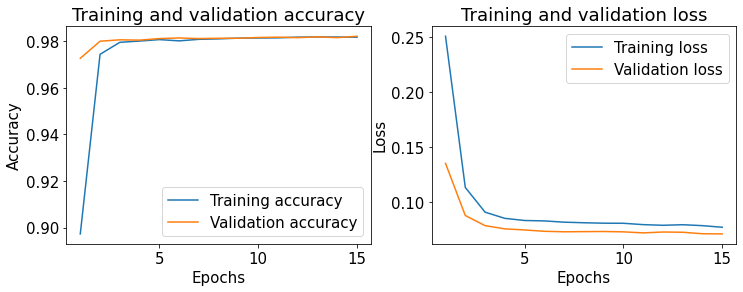

In [37]:
history_dict = history.history

# Extracting accuracy and loss
train_acc = history_dict['accuracy']
val_acc = history_dict['val_accuracy']
train_loss = history_dict['loss']
val_loss = history_dict['val_loss']

# Number of epochs
epochs = range(1, 16)

plt.figure(figsize=(12, 4))


plt.subplot(1, 2, 1)
plt.plot(epochs, train_acc, label='Training accuracy')
plt.plot(epochs, val_acc, label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(epochs, train_loss, label='Training loss')
plt.plot(epochs, val_loss, label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

469/469 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step


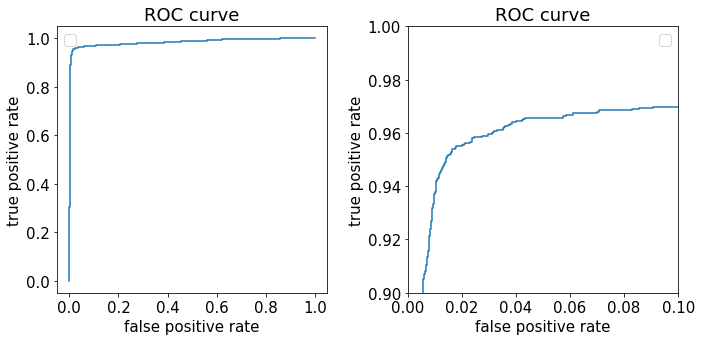

In [42]:
y_probs = model.predict(X_val).ravel()

fpr, tpr, thresholds = roc_curve(y_val, y_probs)


# Plot della ROC curve

fig, (ax1, ax2) = plt.subplots(1,2, figsize=(10,5))


ax1.plot(fpr, tpr)
ax2.plot(fpr, tpr)   
    

ax1.set_xlabel("false positive rate")
ax1.set_ylabel("true positive rate")
ax2.set_xlabel("false positive rate")
ax2.set_ylabel("true positive rate")

ax1.set_title('ROC curve')
ax2.set_title('ROC curve')

ax2.set_xlim(0,0.1)
ax2.set_ylim(0.9,1)

fig.tight_layout()
ax1.legend()
ax2.legend()
plt.show()

It's a good result but even without deep learning we obtained almost an equally well result. Maybe using deep learning is too much for this. 

In [43]:
y_probs_train = model.predict(X_train).ravel()
y_probs_val = model.predict(X_val).ravel()

binary_predictions_train = (y_probs_train > 0.5).astype(int)
binary_predictions_val = ( y_probs_val > 0.5).astype(int)


1094/1094 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step
469/469 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
[1 0 0 0 1 0 0 1 0 0]


(0.0, 3.0)

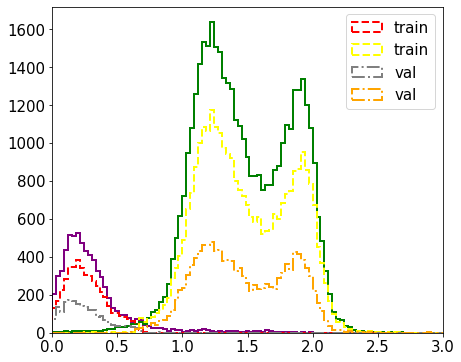

In [45]:
plt.hist(ug[labels_ == 1],histtype='step',bins=np.linspace(0,3,100), color = 'purple', linewidth = 2);
plt.hist(ug[labels_ == 0],histtype='step',bins=np.linspace(0,3,100), color = 'green', linewidth = 2);


plt.hist(X_train[:,0][binary_predictions_train == 1],histtype='step',bins=np.linspace(0,3,100), color = 'red', linewidth = 2,  linestyle='--', label = 'train');
plt.hist(X_train[:,0][binary_predictions_train == 0],histtype='step',bins=np.linspace(0,3,100), color = 'yellow', linewidth = 2,  linestyle='--', label = 'train');

plt.hist(X_val[:,0][binary_predictions_val == 1],histtype='step',bins=np.linspace(0,3,100), color = 'grey', linewidth = 2,  linestyle='-.', label = 'val');
plt.hist(X_val[:,0][binary_predictions_val == 0],histtype='step',bins=np.linspace(0,3,100), color = 'orange', linewidth = 2,  linestyle='-.', label = 'val');


plt.legend()
plt.xlim(0,3)

On the full dataset.

1563/1563 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step


(0.0, 3.0)

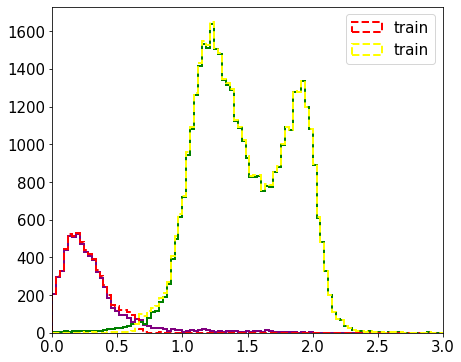

In [46]:
y_probs = model.predict(X).ravel()

binary_predictions = (y_probs> 0.5).astype(int)



plt.hist(ug[labels_ == 1],histtype='step',bins=np.linspace(0,3,100), color = 'purple', linewidth = 2);
plt.hist(ug[labels_ == 0],histtype='step',bins=np.linspace(0,3,100), color = 'green', linewidth = 2);


plt.hist(X[:,0][binary_predictions == 1],histtype='step',bins=np.linspace(0,3,100), color = 'red', linewidth = 2,  linestyle='--', label = 'train');
plt.hist(X[:,0][binary_predictions == 0],histtype='step',bins=np.linspace(0,3,100), color = 'yellow', linewidth = 2,  linestyle='--', label = 'train');



plt.legend()
plt.xlim(0,3)

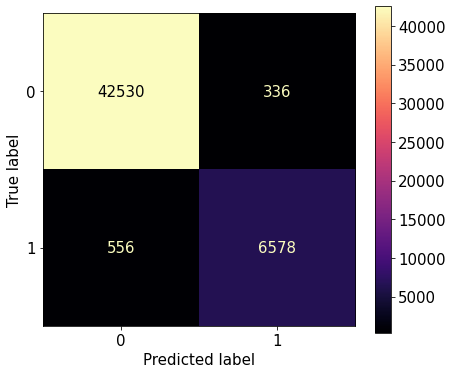

In [50]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

Conf_matrix = confusion_matrix(labels_, binary_predictions)
disp = ConfusionMatrixDisplay(confusion_matrix=Conf_matrix)

disp.plot( cmap = 'magma')
plt.show()